Author: Pascal, pascal@bayesimpact.org

Date: 2016-03-27

# ROME update from v330 to v331

In March 2017 a new version of the ROME was realeased. I want to investigate what changed and whether we need to do anything about it.

You might not be able to reproduce this notebook, mostly because it requires to have the two versions of the ROME in your `data/rome/csv` folder which happens only just before we switch to v330. You will have to trust me on the results ;-)

In [1]:
import collections
import glob
import os
from os import path

import matplotlib_venn
import pandas

rome_path = path.join(os.getenv('DATA_FOLDER'), 'rome/csv')

OLD_VERSION = '330'
NEW_VERSION = '331'

old_version_files = frozenset(glob.glob(rome_path + '/*%s*' % OLD_VERSION))
new_version_files = frozenset(glob.glob(rome_path + '/*%s*' % NEW_VERSION))

First let's check if there are new or deleted files (only matching by file names).

In [2]:
new_files = new_version_files - frozenset(f.replace(OLD_VERSION, NEW_VERSION) for f in old_version_files)
deleted_files = old_version_files - frozenset(f.replace(NEW_VERSION, OLD_VERSION) for f in new_version_files)

print('%d new files' % len(new_files))
print('%d deleted files' % len(deleted_files))

0 new files
0 deleted files


So we have the same set of files: good start.

Now let's set up a dataset that, for each table, links the old file and the new file.

In [3]:
new_to_old = dict((f, f.replace(NEW_VERSION, OLD_VERSION)) for f in new_version_files)

# Load all datasets.
Dataset = collections.namedtuple('Dataset', ['basename', 'old', 'new'])
data = [Dataset(
        basename=path.basename(f),
        old=pandas.read_csv(f.replace(NEW_VERSION, OLD_VERSION)),
        new=pandas.read_csv(f))
    for f in sorted(new_version_files)]

def find_dataset_by_name(data, partial_name):
    for dataset in data:
        if 'unix_%s_v%s_utf8.csv' % (partial_name, NEW_VERSION) == dataset.basename:
            return dataset
    raise ValueError('No dataset named %s, the list is\n%s' % (partial_name, [dataset.basename for d in data]))

Let's make sure the structure hasn't changed:

In [4]:
for dataset in data:
    if set(dataset.old.columns) != set(dataset.new.columns):
        print('Columns of %s have changed.' % dataset.basename)

All files have the same columns as before: still good.

In [5]:
untouched = 0
for dataset in data:
    diff = len(dataset.new.index) - len(dataset.old.index)
    if diff > 0:
        print('%d values added in %s' % (diff, dataset.basename))
    elif diff < 0:
        print('%d values removed in %s' % (diff, dataset.basename))
    else:
        untouched += 1
print('%d/%d files with the same number of rows' % (untouched, len(data)))

219 values added in unix_coherence_item_v331_utf8.csv
79 values added in unix_item_v331_utf8.csv
219 values added in unix_liens_rome_referentiels_v331_utf8.csv
86 values added in unix_referentiel_activite_riasec_v331_utf8.csv
-22 values removed in unix_referentiel_activite_v331_utf8.csv
16/21 files with the same number of rows


So we have minor changes in 5 files. At one point we cared about `referentiel_activite` and `referentiel_activite_riasec` but have no concrete application for now.

The only interesting ones are in `item` and `liens_rome_referentiels`, so let's see more precisely.

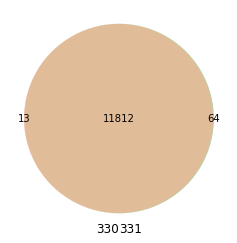

In [6]:
items = find_dataset_by_name(data, 'item')

new_items = set(items.new.code_ogr) - set(items.old.code_ogr)
obsolete_items = set(items.old.code_ogr) - set(items.new.code_ogr)
stable_items = set(items.new.code_ogr) & set(items.old.code_ogr)

_ = matplotlib_venn.venn2((len(obsolete_items), len(new_items), len(stable_items)), (OLD_VERSION, NEW_VERSION))

As anticipated it is a very minor change: some items are now obsolete and new ones have been created. Let's have a look.

In [7]:
items.old[items.old.code_ogr.isin(obsolete_items)].tail()

,code_ogr,libelle,code_type_referentiel,code_ref_rubrique,code_tete_rgpmt,libelle_activite_impression,libelle_en_tete_regroupement
11732,125599,Techniques de gravure,1,7,NaN,NaN,NaN
11838,125719,Dératisation,1,7,NaN,NaN,NaN
11871,125757,Concevoir les objets et matériels nécessaires ...,2,6,NaN,NaN,NaN
11893,125784,Stérilisation,1,10,NaN,NaN,NaN
11894,125784,Stérilisation,1,7,NaN,NaN,NaN


In [8]:
items.new[items.new.code_ogr.isin(new_items)].head()

,code_ogr,libelle,code_type_referentiel,code_ref_rubrique,code_tete_rgpmt,libelle_activite_impression,libelle_en_tete_regroupement
5123,113235,Langage informatique Apache,1,10,NaN,NaN,NaN
5124,113236,Langage informatique CSS,1,10,NaN,NaN,NaN
5128,113250,Système d''exploitation informatique Apache To...,1,10,NaN,NaN,NaN
5130,113268,Système d''exploitation informatique VirtualBox,1,10,NaN,NaN,NaN
5132,113281,Langage informatique Script Shell,1,10,NaN,NaN,NaN


Those entries look legitimate.

The changes in `liens_rome_referentiels` include changes for those items, so let's only check the changes not related to those.

In [9]:
links = find_dataset_by_name(data, 'liens_rome_referentiels')
old_links_on_stable_items = links.old[links.old.code_ogr.isin(stable_items)]
new_links_on_stable_items = links.new[links.new.code_ogr.isin(stable_items)]

old = old_links_on_stable_items[['code_rome', 'code_ogr']]
new = new_links_on_stable_items[['code_rome', 'code_ogr']]

links_merged = old.merge(new, how='outer', indicator=True)
links_merged['_diff'] = links_merged._merge.map({'left_only': 'removed', 'right_only': 'added'})
links_merged._diff.value_counts()

added      49
removed     3
Name: _diff, dtype: int64

So in addition to the added and remove items, there are 52 fixes. Let's have a look:

In [10]:
job_group_names = find_dataset_by_name(data, 'referentiel_code_rome').old.set_index('code_rome').libelle_rome
item_names = items.new.set_index('code_ogr').libelle.drop_duplicates()
links_merged['job_group_name'] = links_merged.code_rome.map(job_group_names)
links_merged['item_name'] = links_merged.code_ogr.map(item_names)
links_merged.dropna().head(10)

,code_rome,code_ogr,_merge,_diff,job_group_name,item_name
1542,D1403,121251.0,left_only,removed,Relation commerciale auprès de particuliers,Analyser un plan isométrique
24575,N1103,126446.0,left_only,removed,Magasinage et préparation de commandes,Effectuer le service de plats à table selon de...
30158,D1214,118367.0,left_only,removed,Vente en habillement et accessoires de la pers...,Articles de bijouterie / joaillerie
30281,D1202,123058.0,right_only,added,Coiffure,Techniques de séchage
30282,E1103,116902.0,right_only,added,Communication,Stratégies de communication interne
30283,E1103,116903.0,right_only,added,Communication,Stratégies de communication externe
30284,E1103,117426.0,right_only,added,Communication,Communication interne
30285,E1103,117427.0,right_only,added,Communication,Communication externe
30286,D1403,102065.0,right_only,added,Relation commerciale auprès de particuliers,Diététique
30287,B1303,117952.0,right_only,added,Gravure - ciselure,Techniques de gravure


Those fixes make sense (not sure why they were not done before, but let's not complain: it is fixed now).

# Conclusion
The new version of ROME, v333, introduces very minor changes which reflect quite well what they wrote in their [changelog](http://www.pole-emploi.org/front/common/tools/load_file.jspz?galleryId=53360&galleryTitle=ROME+Actualisation+du+20+mars+2017). The transition should be transparent with a very small advantage on the new one.